In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import faiss

import seaborn as sns

In [2]:
# sc.set_figure_params(dpi=150, fontsize=9)

In [3]:
visium_human_DLPFC =  ["../../data/visium/DLPFC/region_1/151674_labeled.h5ad","../../data/visium/DLPFC/region_1/151675_labeled.h5ad"]
merfish_mouse_hypothalamic =  ["../../data/merfish/hypothalamic/merfish_layer1_labeled.h5ad","../../data/merfish/hypothalamic/merfish_layer2_labeled.h5ad"]
stereo_mouse_embryo =  ["../../data/stereo_seq/counts/E15.5/count_E15.5_E1S1_filter_labeled.h5ad","../../data/stereo_seq/counts/E15.5/count_E15.5_E1S2_filter_labeled.h5ad"]

# Inside the dataset

In [4]:
result_dict = {}
for adatas in [visium_human_DLPFC, merfish_mouse_hypothalamic, stereo_mouse_embryo]:
    tech_dict = {}
    if 'visium' and 'DLPFC' in adatas[0]:
        biology_meta = 'cell_type'
        tech = 'Visium'
    elif 'merfish' in adatas[0]:
        biology_meta = 'Cell_class'
        tech = 'MERFISH'
    elif 'stereo' in adatas[0]:
        biology_meta = 'annotation'
        tech = 'Stereo-seq'
    print(f'--------{tech}---------')
    for i, adata in enumerate(adatas):
        adata1 = sc.read_h5ad(adata)
        query_coord = adata1.obsm['spatial'].astype('float32').copy()
        ref_coord = adata1.obsm['spatial'].astype('float32').copy()
        
        # nearest neighbor defining
        index = faiss.IndexFlatL2(2) 
        index.add(ref_coord)   
        distance, orders = index.search(query_coord, 3)
        order = orders[:,1].flatten() # exclude it self

        map_df = pd.DataFrame({'index':range(adata1.shape[0]),
                               'meta':adata1.obs[biology_meta].astype(str),
                               'map':order,
                               'map_meta':adata1.obs[biology_meta][order].values.astype(str)
                                })

        print(f'contain {map_df.shape[0]} cells')
        res = dict((map_df['meta'] == map_df['map_meta']).value_counts())
        ratio = res[True]/map_df.shape[0]
        print(res)
        print(ratio)
        tech_dict[f'slice_{i}'] = ratio
        print('\n')
    result_dict[tech] = tech_dict

--------Visium---------
contain 3635 cells
{True: 2899, False: 736}
0.7975240715268226


contain 3566 cells
{True: 2680, False: 886}
0.7515423443634324


--------MERFISH---------
contain 6412 cells
{False: 4250, True: 2162}
0.33718028696194635


contain 6507 cells
{False: 4087, True: 2420}
0.37190717688643


--------Stereo-seq---------
contain 101837 cells
{True: 91343, False: 10494}
0.8969529738700079


contain 96221 cells
{True: 85305, False: 10916}
0.8865528315024787




In [5]:
result = pd.DataFrame(result_dict)
result = pd.melt(result.reset_index(), id_vars='index')
result

,index,variable,value
0,slice_0,Visium,0.797524
1,slice_1,Visium,0.751542
2,slice_0,MERFISH,0.337180
3,slice_1,MERFISH,0.371907
4,slice_0,Stereo-seq,0.896953
5,slice_1,Stereo-seq,0.886553


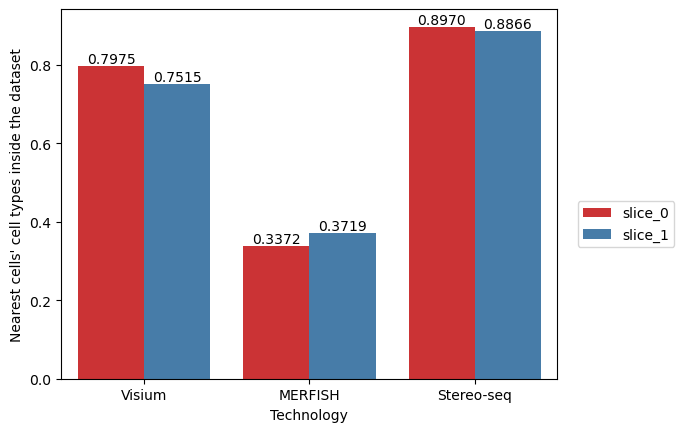

In [6]:
# seaborn grouped barplot
ax = sns.barplot(data=result, x='variable', y='value', hue='index', palette='Set1')
# set x label
ax.set_xlabel('Technology')
ax.set_ylabel("Nearest cells' cell types inside the dataset")
ax.legend(bbox_to_anchor = (1.25, 0.5))
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')

# Cross the dataset

In [7]:
result_dict = {}
for adatas in [visium_human_DLPFC, merfish_mouse_hypothalamic, stereo_mouse_embryo]:
    tech_dict = {}
    if 'visium' and 'DLPFC' in adatas[0]:
        biology_meta = 'cell_type'
        tech = 'Visium'
    elif 'merfish' in adatas[0]:
        biology_meta = 'Cell_class'
        tech = 'MERFISH'
    elif 'stereo' in adatas[0]:
        biology_meta = 'annotation'
        tech = 'Stereo-seq'
    adata1 = sc.read_h5ad(adatas[0])
    adata2 = sc.read_h5ad(adatas[1])
    # scale coordinate
    query_coord = adata1.obsm['spatial'].astype('float32').copy()
    ref_coord = adata2.obsm['spatial'].astype('float32').copy()
    query_coord = (query_coord-np.min(query_coord))/(np.max(query_coord)-np.min(query_coord))
    ref_coord = (ref_coord-np.min(ref_coord))/(np.max(ref_coord)-np.min(ref_coord))
    
    # nearest neighbor defining
    index = faiss.IndexFlatL2(2) 
    index.add(ref_coord)   
    distance, orders = index.search(query_coord, 5)
    order = orders[:,0].flatten()

    map_df = pd.DataFrame({'index':range(adata1.shape[0]),
                           'meta':adata1.obs[biology_meta].astype(str),
                           'map':order,
                           'map_meta':adata2.obs[biology_meta][order].values.astype(str)
                            })
    print(f'--------{tech}---------')
    print(f'contain {map_df.shape[0]} cells')
    res = dict((map_df['meta'] == map_df['map_meta']).value_counts())
    ratio = res[True]/map_df.shape[0]
    print(res)
    print(ratio)
    result_dict[tech] = ratio

--------Visium---------
contain 3635 cells
{True: 2578, False: 1057}
0.7092159559834939
--------MERFISH---------
contain 6412 cells
{False: 4631, True: 1781}
0.27776044915782905
--------Stereo-seq---------
contain 101837 cells
{True: 53600, False: 48237}
0.5263312941268891


In [8]:
result = pd.DataFrame(result_dict, index=['value']).T
result['Technology'] = result.index
result

,value,Technology
Visium,0.709216,Visium
MERFISH,0.277760,MERFISH
Stereo-seq,0.526331,Stereo-seq


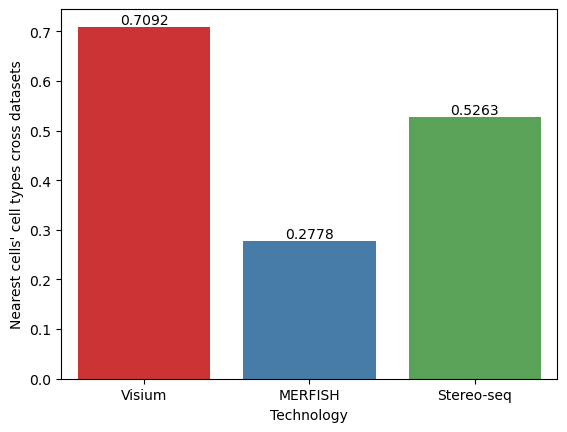

In [9]:
# seaborn grouped barplot
ax = sns.barplot(data=result,x='Technology', y='value', palette='Set1')
# set x label
ax.set_xlabel('Technology')
ax.set_ylabel("Nearest cells' cell types cross datasets")
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')